# Fig 1: maps of Antarctic and Greenland periphery 

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import shapely.geometry as shpg

In [2]:
# open zipfile function
import zipfile

def open_zip_shapefile(fpath, exclude_pattern='', include_pattern=''):
    with zipfile.ZipFile(fpath, "r") as z:
        for f in z.filelist:
            if f.filename.endswith('.shp'):
                if exclude_pattern and exclude_pattern in f.filename:
                    continue
                if include_pattern and include_pattern not in f.filename:
                    continue
                fname = f.filename

    return gpd.read_file('zip://' + fpath + '/' + fname)

## Greenland data

- Coastline: https://doi.org/10.5285/8cecde06-8474-4b58-a9cb-b820fa4c9429 (BAS)
- RGI06: https://www.glims.org/RGI/rgi60_dl.html
- Ice-sheet basins: https://datadryad.org/stash/dataset/doi:10.7280/D1WT11

In [3]:
dfg_coast = open_zip_shapefile('../data/shapes/Greenland_coast.zip')

In [4]:
dfg_rgi = open_zip_shapefile('../data/shapes/05_rgi60_GreenlandPeriphery.zip')
dfg_rgi = dfg_rgi.to_crs(dfg_coast.crs)

In [5]:
dfg_ice = open_zip_shapefile('../data/shapes/doi_10.7280_D1WT11__v1.zip')
dfg_ice = dfg_ice.to_crs(dfg_coast.crs)

In [6]:
# We don't plot the basins of the ice sheet 
dfg_ice['A'] = 1
dfg_ice = dfg_ice.dissolve(by='A')

In [7]:
# Because the dissolve does not work perfectly
dfg_hide = open_zip_shapefile('../data/shapes/to_hide.zip')
dfg_hide = dfg_hide.to_crs(dfg_coast.crs)

In [8]:
bbg = dfg_rgi.total_bounds

## Antarctica data

- all outlines from https://doi.org/10.3189/2013AoG63A377 (Bliss et al)
- removed glaciers in Millan et al 22 obtained from the author

In [9]:
dfa = open_zip_shapefile('../data/shapes/add_coastpoly_minus_rockReClassVelLamb.zip')
dfag = open_zip_shapefile('../data/shapes/add_glaciers_icecaps5.zip')
dfag = dfag.to_crs(dfa.crs)

In [10]:
dfam = open_zip_shapefile('../data/shapes/rgi19_removed_glaciers_millan.zip')
dfam = dfam.to_crs(dfa.crs)

In [11]:
bba = dfa.total_bounds

In [12]:
# Find out how much area is outside the bounds

In [13]:
bounds = dfag.bounds
df_out = dfag.loc[(bounds.maxx < bba[0]) | (bounds.minx > bba[2]) | (bounds.miny > bba[3]) | (bounds.maxy < bba[1])]

In [14]:
df_out['Area'].sum() / dfag['Area'].sum()

0.026166702925791624

In [15]:
df_out['Area'].sum() * 1e-6, dfag['Area'].sum() * 1e-6

(3476.6950393718294, 132867.1422315484)

## Plot

In [16]:
cols = sns.color_palette("bright")  # bright
cols

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [17]:
c_ocean = '#e9f3ff' # '#e5f1ff'
c_icesheet = 'white'
c_land = '#bbb4af'
c_glaciers = cols[3]
c_glaciers_1 = cols[1]
c_glaciers_2 = cols[0]
c_shelf = cols[-1]
c_rise = cols[4]
c_tongue = '#266bc4'
c_removed = cols[-2]

In [18]:
xg = bbg[[0, 2]] + np.array([-5e4, 5e4])
yg = bbg[[1, 3]] + np.array([-5e4, 5e4])

xa = bba[[0, 2]] + np.array([-1e5, 1e5])
ya = bba[[1, 3]] + np.array([-1e5, 1e5])

rxg = xg[1] - xg[0]
ryg = yg[1] - yg[0]

rxa = xa[1] - xa[0]
rya = ya[1] - ya[0]

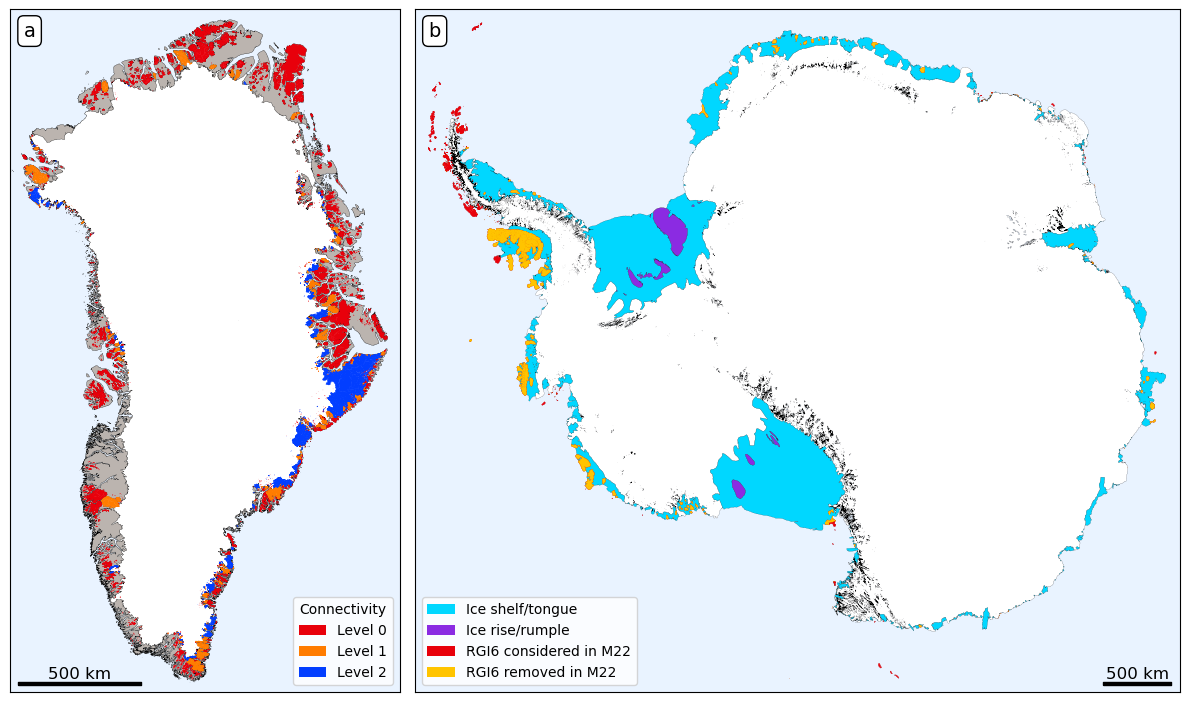

In [19]:
f = plt.figure(figsize=(12, 8))

gs1 = gridspec.GridSpec(1, 2, width_ratios=[rxg / ryg, rxa / rya])
ax1 = f.add_subplot(gs1[0])
ax2 = f.add_subplot(gs1[1])

# GRL
ax = ax1
ax.set_facecolor(c_ocean)

dfg_coast.plot(ax=ax, edgecolor='k', facecolor=c_land, linewidth=0.2);
dfg_ice.plot(ax=ax, edgecolor='k', facecolor=c_icesheet, linewidth=0.2);
dfg_hide.plot(ax=ax, edgecolor=c_icesheet, facecolor=c_icesheet);

dfg_rgi.loc[dfg_rgi.Connect == 0].plot(ax=ax, edgecolor=c_glaciers, facecolor=c_glaciers, linewidth=0.2);
dfg_rgi.loc[dfg_rgi.Connect == 1].plot(ax=ax, edgecolor=c_glaciers_1, facecolor=c_glaciers_1, linewidth=0.2);
dfg_rgi.loc[dfg_rgi.Connect == 2].plot(ax=ax, edgecolor=c_glaciers_2, facecolor=c_glaciers_2, linewidth=0.2);

ax.set_xlim(xg);
ax.set_ylim(yg);
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

handles = []
handles.append(mpatches.Patch(facecolor=c_glaciers, label='Level 0'))
handles.append(mpatches.Patch(facecolor=c_glaciers_1, label='Level 1'))
handles.append(mpatches.Patch(facecolor=c_glaciers_2, label='Level 2'))
ax.legend(handles=handles, loc='lower right', title='Connectivity');

# Scale
w = 5e5
h = 0.004
l = 0.02
t = 0.01
xc = [xg[0] + rxg*l, xg[0] + rxg*l + w, xg[0] + rxg*l + w, xg[0] + rxg*l]
yc = [yg[0] + ryg*t, yg[0] + ryg*t, yg[0] + ryg*t+ h*ryg, yg[0] + ryg*t + h*ryg]
gpd.GeoSeries([shpg.Polygon(np.array([xc, yc]).T)]).plot(ax=ax, facecolor='k', edgecolor='k')
ax.text((xc[0] + xc[1])/2, yc[1] + ryg * t, '500 km', ha='center', fontsize=12)

# place a text box in upper left in axes coords
ax.text(0.02 * ryg / rxg, 0.96, 'a', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'edgecolor':'k', 'boxstyle':'round'})

# AA
ax = ax2
ax.set_facecolor(c_ocean)

dfa.loc[dfa.cst00srf == 'land'].plot(ax=ax, edgecolor='k', facecolor=c_icesheet, linewidth=0.1);
dfa.loc[dfa.cst00srf == 'ice shelf'].plot(ax=ax, edgecolor='k', facecolor=c_shelf, linewidth=0.1);
dfa.loc[dfa.feat_type == 'ice rise'].plot(ax=ax, edgecolor='k', facecolor=c_rise, linewidth=0.1);
dfa.loc[dfa.feat_type == 'rumple'].plot(ax=ax, edgecolor='k', facecolor=c_rise, linewidth=0.1);
dfa.loc[dfa.cst00srf == 'ice tongue'].plot(ax=ax, edgecolor='k', facecolor=c_shelf, linewidth=0.1);

dfag.plot(ax=ax, edgecolor=c_glaciers, facecolor=c_glaciers, linewidth=0.2);
dfam.plot(ax=ax, edgecolor=c_removed, facecolor=c_removed, linewidth=0.2);

ax.set_xlim(xa);
ax.set_ylim(ya);
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False) 

handles = []
handles.append(mpatches.Patch(facecolor=c_shelf, label='Ice shelf/tongue'))
handles.append(mpatches.Patch(facecolor=c_rise, label='Ice rise/rumple'))
handles.append(mpatches.Patch(facecolor=c_glaciers, label='RGI6 considered in M22'))
handles.append(mpatches.Patch(facecolor=c_removed, label='RGI6 removed in M22'))
ax.legend(handles=handles, loc='lower left');

# Scale
l = 0.9
xc = [xa[0] + rxa*l, xa[0] + rxa*l + w, xa[0] + rxa*l + w, xa[0] + rxa*l]
yc = [ya[0] + rya*t, ya[0] + rya*t, ya[0] + rya*t+ h*rya, ya[0] + rya*t + h*rya]
gpd.GeoSeries([shpg.Polygon(np.array([xc, yc]).T)]).plot(ax=ax, facecolor='k', edgecolor='k')
ax.text((xc[0] + xc[1])/2, yc[1]+rya*t, '500 km', ha='center', fontsize=12)

ax.text(0.02 * rya / rxa, 0.96, 'b', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'edgecolor':'k', 'boxstyle':'round'})

plt.tight_layout()
plt.savefig('../figures/plot_maps_bright.png', dpi=300, bbox_inches='tight');
plt.savefig('../figures/plot_maps_bright.tiff', dpi=300, bbox_inches='tight');